In [ ]:
print(data.iloc[0])  # Print the first row of the dataset


price                13300000
area                     7420
bedrooms                    4
bathrooms                   2
stories                     3
mainroad                  yes
guestroom                  no
basement                   no
hotwaterheating            no
airconditioning           yes
parking                     2
prefarea                  yes
furnishingstatus    furnished
Name: 0, dtype: object


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('housing.csv')

X = data.drop('price', axis=1)
y = data['price']

categorical_cols = X.select_dtypes(include=['object']).columns

print(categorical_cols)

X = X.drop(categorical_cols, axis=1)

print(X.columns)

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X.shape)

print(X[:5])


Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')
Index(['area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')
(545, 5)
[[ 1.04672629  1.40341936  1.42181174  1.37821692  1.51769249]
 [ 1.75700953  1.40341936  5.40580863  2.53202371  2.67940935]
 [ 2.21823241  0.04727831  1.42181174  0.22441013  1.51769249]
 [ 1.08362412  1.40341936  1.42181174  0.22441013  2.67940935]
 [ 1.04672629  1.40341936 -0.57018671  0.22441013  1.51769249]]


Epoch 50/500, Train Loss: 0.41860708594322205, Val Loss: 0.7583675980567932
Epoch 100/500, Train Loss: 0.38276368379592896, Val Loss: 0.7449686527252197
Epoch 150/500, Train Loss: 0.3526999354362488, Val Loss: 0.754923939704895
Epoch 200/500, Train Loss: 0.3417068123817444, Val Loss: 0.7675081491470337
Epoch 250/500, Train Loss: 0.2866186797618866, Val Loss: 0.7892889976501465
Epoch 300/500, Train Loss: 0.2940314710140228, Val Loss: 0.7793500423431396
Epoch 350/500, Train Loss: 0.285376638174057, Val Loss: 0.7936012744903564
Epoch 400/500, Train Loss: 0.2839704751968384, Val Loss: 0.805740475654602
Epoch 450/500, Train Loss: 0.2653936445713043, Val Loss: 0.8067125082015991
Epoch 500/500, Train Loss: 0.25354158878326416, Val Loss: 0.8022280931472778


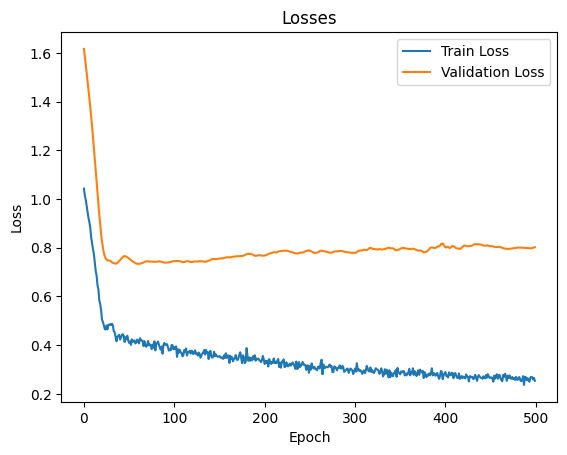

Final Train R^2: 0.7749901413917542
Final Val R^2: 0.5106242299079895
Total Params: 11137


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Define model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model, loss function, and optimizer
model = MLP(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_loss, val_loss = [], []
for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(X_train)
    loss = criterion(output, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss_val = criterion(val_output, y_val)

    train_loss.append(loss.item())
    val_loss.append(val_loss_val.item())

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/500, Train Loss: {loss.item()}, Val Loss: {val_loss_val.item()}')

# Plot losses
plt.plot(range(500), train_loss, label='Train Loss')
plt.plot(range(500), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses')
plt.show()

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_val_pred = model(X_val)

y_train_pred = scaler_y.inverse_transform(y_train_pred.detach().numpy())
y_val_pred = scaler_y.inverse_transform(y_val_pred.detach().numpy())
y_train = scaler_y.inverse_transform(y_train.numpy())
y_val = scaler_y.inverse_transform(y_val.numpy())

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Final Train R^2: {train_r2}')
print(f'Final Val R^2: {val_r2}')
print(f'Total Params: {sum(p.numel() for p in model.parameters())}')


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('housing.csv')

# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

# Convert boolean to 1/0
X = X.astype(int)

# Scale numerical columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Check shape and columns
print(X.shape)
print(X.columns)

# Sample data
print(X.head())


(545, 20)
Index(['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_no',
       'mainroad_yes', 'guestroom_no', 'guestroom_yes', 'basement_no',
       'basement_yes', 'hotwaterheating_no', 'hotwaterheating_yes',
       'airconditioning_no', 'airconditioning_yes', 'prefarea_no',
       'prefarea_yes', 'furnishingstatus_furnished',
       'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished'],
      dtype='object')
       area  bedrooms  bathrooms   stories   parking  mainroad_no  \
0  1.046726  1.403419   1.421812  1.378217  1.517692            0   
1  1.757010  1.403419   5.405809  2.532024  2.679409            0   
2  2.218232  0.047278   1.421812  0.224410  1.517692            0   
3  1.083624  1.403419   1.421812  0.224410  2.679409            0   
4  1.046726  1.403419  -0.570187  0.224410  1.517692            0   

   mainroad_yes  guestroom_no  guestroom_yes  basement_no  basement_yes  \
0             1             1              0            1          

Epoch 50/500, Train Loss: 0.28186020255088806, Validation Loss: 0.575410783290863
Epoch 100/500, Train Loss: 0.21228547394275665, Validation Loss: 0.5737559199333191
Epoch 150/500, Train Loss: 0.17224271595478058, Validation Loss: 0.5780186057090759
Epoch 200/500, Train Loss: 0.16293729841709137, Validation Loss: 0.5780343413352966
Epoch 250/500, Train Loss: 0.1263464242219925, Validation Loss: 0.5780994892120361
Epoch 300/500, Train Loss: 0.12844324111938477, Validation Loss: 0.5997630953788757
Epoch 350/500, Train Loss: 0.11241543292999268, Validation Loss: 0.5823991894721985
Epoch 400/500, Train Loss: 0.09183338284492493, Validation Loss: 0.5855870842933655
Epoch 450/500, Train Loss: 0.08285045623779297, Validation Loss: 0.6083117127418518
Epoch 500/500, Train Loss: 0.07963524758815765, Validation Loss: 0.5938603281974792


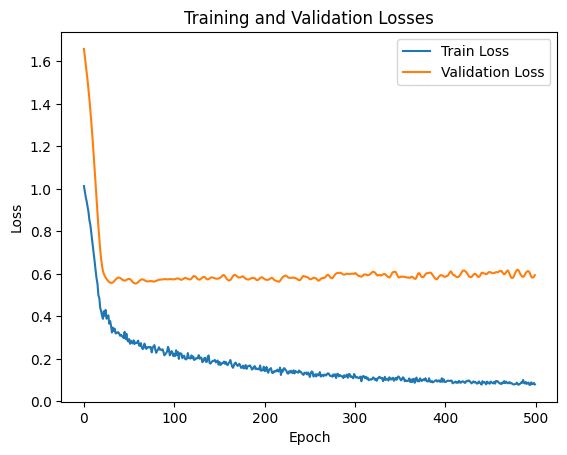

Final Train Loss: 0.07963524758815765, Final Validation Loss: 0.5938603281974792
Model Parameters: 13057
Final Train R^2: 0.9557104110717773
Final Val R^2: 0.6377328634262085
Total Params: 13057


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and target
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Define model
class MLP(nn.Module):
    def __init__(self, in_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Init model, loss, optimizer
model = MLP(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses, val_losses = [], []
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')

# Plot
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

# Report final results
print(f'Final Train Loss: {train_losses[-1]}, Final Validation Loss: {val_losses[-1]}')
print(f'Model Parameters: {sum(p.numel() for p in model.parameters())}')

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor)
    y_val_pred = model(X_val_tensor)

y_train_pred = scaler_y.inverse_transform(y_train_pred.detach().numpy())
y_val_pred = scaler_y.inverse_transform(y_val_pred.detach().numpy())
y_train = scaler_y.inverse_transform(y_train_tensor.numpy())
y_val = scaler_y.inverse_transform(y_val_tensor.numpy())

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Final Train R^2: {train_r2}')
print(f'Final Val R^2: {val_r2}')
print(f'Total Params: {sum(p.numel() for p in model.parameters())}')



Epoch 50/500, Train Loss: 0.6720137000083923, Validation Loss: 0.7757815718650818
Epoch 100/500, Train Loss: 0.5096673965454102, Validation Loss: 0.6544119715690613
Epoch 150/500, Train Loss: 0.4805501103401184, Validation Loss: 0.6503202319145203
Epoch 200/500, Train Loss: 0.3445502817630768, Validation Loss: 0.6543896794319153
Epoch 250/500, Train Loss: 0.3173796534538269, Validation Loss: 0.6408407092094421
Epoch 300/500, Train Loss: 0.31784695386886597, Validation Loss: 0.6676331758499146
Epoch 350/500, Train Loss: 0.35837242007255554, Validation Loss: 0.6493651270866394
Epoch 400/500, Train Loss: 0.3002450466156006, Validation Loss: 0.6542827486991882
Epoch 450/500, Train Loss: 0.2900747060775757, Validation Loss: 0.6424207091331482
Epoch 500/500, Train Loss: 0.26039648056030273, Validation Loss: 0.6602045893669128


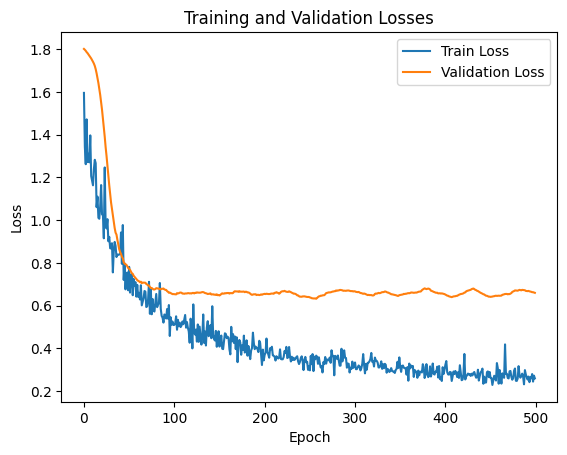

Final Train Loss: 0.26039648056030273, Final Validation Loss: 0.6602045893669128
Model Params: 725473
Final Train R^2: 0.8783737421035767
Final Val R^2: 0.5972615480422974
Total Params: 725473


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and target
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Define model
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.batch_norm4 = nn.BatchNorm1d(128)
        self.batch_norm5 = nn.BatchNorm1d(64)
        self.batch_norm6 = nn.BatchNorm1d(32)
        self.batch_norm7 = nn.BatchNorm1d(16)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.batch_norm4(x)
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.batch_norm5(x)
        x = self.dropout(x)
        x = self.relu(self.fc6(x))
        x = self.batch_norm6(x)
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.batch_norm7(x)
        x = self.dropout(x)
        x = self.fc8(x)
        return x


# Init model, loss, optimizer
model = MLP(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses, val_losses = [], []
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')

# Plot
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

# Report results
print(f'Final Train Loss: {train_losses[-1]}, Final Validation Loss: {val_losses[-1]}')
print(f'Model Params: {sum(p.numel() for p in model.parameters())}')

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor)
    y_val_pred = model(X_val_tensor)

y_train_pred = scaler_y.inverse_transform(y_train_pred.detach().numpy())
y_val_pred = scaler_y.inverse_transform(y_val_pred.detach().numpy())
y_train = scaler_y.inverse_transform(y_train_tensor.numpy())
y_val = scaler_y.inverse_transform(y_val_tensor.numpy())

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Final Train R^2: {train_r2}')
print(f'Final Val R^2: {val_r2}')
print(f'Total Params: {sum(p.numel() for p in model.parameters())}')

